In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
import numpy as np

In [5]:
dating = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/stat/10/dating_data.csv')

In [2]:
dating = pd.read_csv("dating_data.csv") #читаем данные

In [6]:
dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [7]:
dating.groupby("group").size() #сколько наблюдений в каждой группе

group
0    4792
1    9722
dtype: int64

In [9]:
dating.groupby("group").user_id_1.nunique() #сколько юзеров в каждой группе

group
0    501
1    499
Name: user_id_1, dtype: int64

In [10]:
dating.groupby("group").user_id_2.nunique() #и вторых юзеров тоже

group
0    501
1    499
Name: user_id_2, dtype: int64

Нет ли пересечения между группами пользователей? Для проверки этого нам пригодятся множества:

In [11]:
gr_01 = set(dating.query("group==0").user_id_1)
gr_11 = set(dating.query("group==1").user_id_1)

gr_01.intersection(gr_11)

set()

In [12]:
gr_02 = set(dating.query("group==0").user_id_2)
gr_12 = set(dating.query("group==1").user_id_2)

gr_02.intersection(gr_12)

set()

Пересечений нет

## Гипотеза 1: изменилось соотношение мэтчей и не-мэтчей

Посмотрим на кросстабуляцию:

In [13]:
pd.crosstab(dating.group, dating.is_match)

is_match,0,1
group,,
0,3858,934
1,5813,3909


Видим, что в тестовой группе увеличилось число мэтчей, так и не мэтчей. Надо это тоже проверить. Проверим тестом хи-квадрат, так как переменные категориальные

In [14]:
exp, obs, stats = pg.chi2_independence(data=dating, 
                                       x="group", 
                                       y="is_match") 

In [15]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


Вне зависимости от того, какой критерий хи-квадрата применяется, все p-value ощутимо < 0.05. То есть, статистически значимо изменилась пропорция мэтчей и не мэтчей. Экспериментальное количество мэтчей выросло в лучшую сторону.

## Гипотеза 2: изменилось число анкет на пользователя

In [16]:
prof_per_user = dating.groupby(["group", "user_id_1"], as_index=False).size()
prof_per_user

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


<AxesSubplot:xlabel='size', ylabel='Count'>

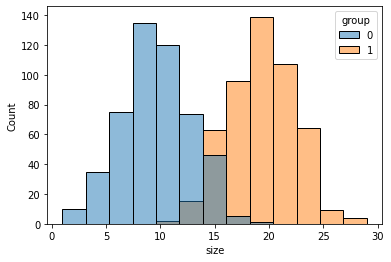

In [17]:
sns.histplot(data=prof_per_user, x="size", hue="group")

Визуально мы видим, что группы отчасти пересекаются, но у первой группы произошел свдиг вперед. Проверим статистически средние.

In [18]:
pg.ttest(x=prof_per_user.query("group==0")["size"], 
         y=prof_per_user.query("group==1")["size"]) #ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


p-val < 0.05. Байес фактор тоже показывает, что альтернативная гипотеза о наличии различий явно вероятней чем нулевая гипотеза. В контрольной группе в среднем было на 10 анкет меньше, чем в экспериментальной. На всякий случай проверю тестом Манна-Уитни стахотическое равновесие (доминирование), то есть случайно взятое значение из первой группы будет больше случайно взятой из нулевой группы.

In [20]:
pg.mwu(x=prof_per_user.query("group==0")["size"], 
       y=prof_per_user.query("group==1")["size"]) #Манн-Уитни

,U-val,alternative,p-val,RBC,CLES
MWU,3316.0,two-sided,6.905155e-157,0.973472,0.013264


Только 1% пользователей контрольной группы является больше тех значений, которые попадаются в тестовой группе. То есть тестовая группа отличается в большую сторону по количеству анкет. 

## Гипотеза 3: изменилось число мэтчей на пользователя

In [21]:
matches_per_user = dating.query("is_match==1").groupby(["group", "user_id_1"], as_index=False).size()
matches_per_user

,group,user_id_1,size
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
915,1,987,8
916,1,992,8
917,1,993,6
918,1,998,10


<AxesSubplot:xlabel='size', ylabel='Count'>

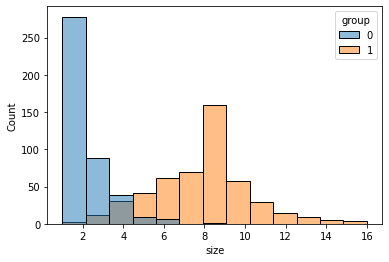

In [22]:
sns.histplot(data=matches_per_user, x="size", hue="group")

Опять же видим различия. Проверим статистически.

In [24]:
pg.ttest(x=matches_per_user.query("group==0")["size"], 
         y=matches_per_user.query("group==1")["size"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-45.232978,744.211281,two-sided,9.229585e-216,"[-5.88, -5.39]",2.843535,3.166e+231,1.0


Видим, что отличается примерно на 5 мэтчей на одного пользователя. 

In [25]:
pg.mwu(x=matches_per_user.query("group==0")["size"], 
       y=matches_per_user.query("group==1")["size"])

,U-val,alternative,p-val,RBC,CLES
MWU,3944.5,two-sided,1.570060e-141,0.962461,0.018769


В одной из групп чаще встречаются более высокие значения, чем в другой.